LaTeX macros (hidden cell)

$$
\renewcommand{\Q}{\mathcal{Q}}
\renewcommand{\ECov}{\boldsymbol{\Sigma}}
\renewcommand{\EMean}{\boldsymbol{\mu}}
\renewcommand{\EAlpha}{\boldsymbol{\alpha}}
\renewcommand{\EBeta}{\boldsymbol{\beta}}
\renewcommand{\P}{\mathcal{P}}
$$

# About
This notebook runs benchmarks ReHLine-PO on a mean-variance problem with transaction costs, i.e.

$$\min_{\mathbf{w} \in \mathbb{R}^n} \frac{\alpha}{2} \mathbf{w}^T \mathbf{G} \mathbf{w} - \mathbf{\mu}^T \mathbf{w} + \sum_{i=1}^n \phi_i(w_i), \; \; \; \; \text{s.t. } \mathbf{A w} + \mathbf{b} \geq 0 (*)$$

 against commercial optimizers like Gurobi and Mosek. 

# Imports and configurations

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
from tqdm import tqdm

# internal utils
from utils import *

from dotenv import load_dotenv
load_dotenv()  # loads environment variables from .env file
dataset_path = os.getenv('DATASET_PATH')


In [4]:
# autoreload modified libraries
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Retrieve data

Please modify this section and consequent logic (if needed) to fit your benchmarking. For this notebook, the following data was used:
1. `mu.pkl`: asset signals of shape `(n_samples, n_assets)`
2. `L.pkl`: factor loadings of the given asset returns on an array of factors of shape `(n_samples, n_assets, n_factors)`

In [5]:
mu_dict = pd.read_pickle(f"{dataset_path}/mu.pkl")
beta_dict = pd.read_pickle(f"{dataset_path}/L.pkl")
len(beta_dict), len(mu_dict)

(79, 79)

In [6]:
n_samples, n_assets, n_factors = len(beta_dict), beta_dict[0].shape[0], beta_dict[0].shape[1]
n_samples, n_assets, n_factors

(79, 5058, 42)

In [7]:
# noise variance ~ var(alpha)
mu_df = pd.DataFrame(mu_dict)
Psi = mu_df.var(axis=1).values
Psi

array([0.01621194, 0.05394101, 0.11801196, ..., 0.03430027, 0.01016757,
       0.01026194])

# Experiment
## Setting

We will compare the performance of ReHLine-based portfolio optimization method against competing methods like MOSEK and GUROBI in solving the Mean-Variance model with transaction costs:

$$\min_{\mathbf{w} \in \R^n} \frac{C}{2} \mathbf{w}^T \hat{\mathbf{G}} \mathbf{w} - \mu^T \mathbf{w} + \sum_{i=1}^n \phi_i(w_i)$$

The experiment will be conducted for the following two types of data:

**Simulated data**

For the simulated data we will assume that
1. $\hat{\mathbf{G}} = \mathbf{\beta} \mathbf{\beta}^T + \lambda \mathbf{I}$ where $\beta \sim Unif(-0.5, 0.5)^{n \times f}$ and $\lambda$ is shrinkage parameter and $f$ is number of factors.
2. $\mu \sim Unif(-0.5, 0.5)^n$

**Real data**


For this experiment, our data consists of factor loadings (or betas) $L$ where we model the covariance matrix as
$$\hat{G} = (\Psi + \mathbf{\beta} \Sigma_f \mathbf{\beta}^T) + \lambda \mathbf{I}$$
where $\Psi$ is noise covariance matrix, which we assume is a diagonal matrix, and $\Sigma_f$ is a covariance matrix of factors and $\lambda$ is a shrinkage parameter. For the sake of the experiment, we will assume $\Sigma_f = \mathbf{I}$ and $\Psi_{ii} \approx Var(\text{asset i return})$.

where $\phi_i$ is a piece-wise linear transaction cost function. Methods will be compared for different complexities (i.e. #linear pieces) of $\phi_i$.


_Remark_: 

Note that although we are (sort of) using a factor modelling approach to capture the covariance of returns, it doesn't have to be the case. So, for the experiment we won't boosting optimization algorithms with factor modelling.

## Simulated data

In [27]:
from itertools import product
from math import prod

risk_aversion = 2.0
V = 1.0 # "maximal volume" of an asset that can be sold/bought
vp, vm = 0.01, 0.02
d_vp, d_vm = vp*0.1, vm*0.15
lb, ub = -1.0, 1.0
n_factors = 40

tol = 1e-4
max_iter = 1000
verbose = 0
trace_freq = 10

Ns = [2**i for i in range(6, 14)]
Ls = [1] # "complexities" of transaction function
lams = [0.05]
methods = ["rehline_po", "gurobi", "mosek"]
n_tries = 5

def run_simulated(lam, method, n_assets, L):
    transaction_costs = create_plqloss_from_volume(n_assets, V, L, vp, vm, d_vp, d_vm)
    mu, beta = random_mu(n_assets), random_beta(n_assets, n_factors)
    Psi = lam * np.ones(n_assets)
    cov = beta @ beta.T + np.diag(Psi)

    start = time.time()
    if method == "rehline_po":
        weights, _ = max_quad_util_portf_rehline_plq(n_assets, mu, cov, transaction_costs,
                                                     risk_aversion, lb, ub, max_iter, tol)
    elif method == "gurobi":
        weights = max_quad_util_portf_gurobi_plq(mu, cov, risk_aversion, 
                                                 transaction_costs, lb, ub)
    elif method == "mosek":
        weights = max_quad_util_portf_mosek_plq(n_assets, mu, cov, transaction_costs,
                                                risk_aversion, lb, ub)
    else:
        raise ValueError("Invalid `method` argument")

    end = time.time()
    return weights, end-start

results_sim = []
n_rows = prod(map(len, (lams, methods, Ns, Ls, range(n_tries))))
for lam, method, n_assets, L, _ in tqdm(product(lams, methods, Ns, Ls, range(n_tries)), 
                                     total=n_rows):
    _weights, elapsed_time =  run_simulated(lam, method, n_assets, L)
    results_sim.append((lam, method, n_assets, L, elapsed_time))

  0%|                                                   | 0/120 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 120/120 [29:58<00:00, 14.99s/it]


In [28]:
data_sim = pd.DataFrame(results_sim, columns=["lam", "method", "n_assets", "L", "elapsed_time"])
data_sim.head()

,lam,method,n_assets,L,elapsed_time
0,0.05,rehline_po,64,1,0.005445
1,0.05,rehline_po,64,1,0.008571
2,0.05,rehline_po,64,1,0.008526
3,0.05,rehline_po,64,1,0.008487
4,0.05,rehline_po,64,1,0.008599


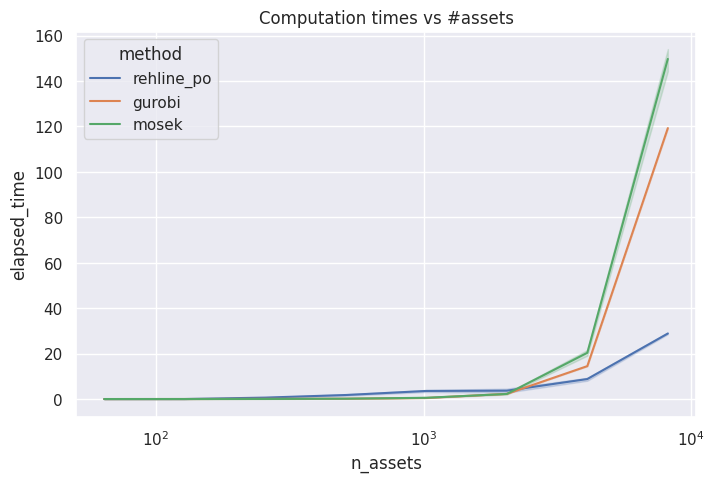

In [32]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
sns.lineplot(data_sim, x="n_assets", y="elapsed_time", hue="method", markers=True, ax=ax)
ax.set_xscale("log")
plt.title(f"Computation times vs #assets")
plt.show()

## Real data

In [ ]:
# this might take several hours with the default arguments
# set `n_tries` accordingly for your convenience
from itertools import product
from math import prod

risk_aversion = 2.0
V = 1.0 # "maximal volume" of an asset that can be sold/bought
vp, vm = 0.01, 0.02
d_vp, d_vm = vp*0.1, vm*0.15
lb, ub = -1.0, 1.0
n_assets, n_factors, n_samples = beta_dict[0].shape[0], beta_dict[0].shape[1], len(beta_dict)

tol = 1e-4
max_iter = 1000
verbose = 0
trace_freq = 10

Ns = [n_assets]
Ls = [1, 5, 10] # "complexities" of transaction function
lams = np.logspace(-3, -1, 5)
methods = ["rehline_po", "gurobi", "mosek"]
n_tries = 5

def run_real(lam, method, n_assets, L, idx):
    transaction_costs = create_plqloss_from_volume(n_assets, V, L, vp, vm, d_vp, d_vm)
    mu, beta = mu_dict[idx], beta_dict[idx]
    Psi = mu_df.var(axis=1).values
    cov = beta @ beta.T + np.diag(Psi) + lam*np.eye(n_assets)

    start = time.time()
    if method == "rehline_po":
        weights, _ = max_quad_util_portf_rehline_plq(n_assets, mu, cov, transaction_costs,
                                                     risk_aversion, lb, ub, max_iter, tol)
    elif method == "gurobi":
        weights = max_quad_util_portf_gurobi_plq(mu, cov, risk_aversion, 
                                                 transaction_costs, lb, ub)
    elif method == "mosek":
        weights = max_quad_util_portf_mosek_plq(n_assets, mu, cov, transaction_costs,
                                                risk_aversion, lb, ub)
    else:
        raise ValueError("Invalid `method` argument")

    end = time.time()
    return weights, end-start

results_real = []
n_rows = prod(map(len, (lams, methods, Ns, Ls, range(n_tries))))
for lam, method, n_assets, L, idx in tqdm(product(lams, methods, Ns, Ls, range(n_tries)), 
                                     total=n_rows):
    _weights, elapsed_time =  run_real(lam, method, n_assets, L, idx)
    results_real.append((lam, method, n_assets, L, elapsed_time))

 56%|████████████████████▋                | 126/225 [1:44:32<1:13:14, 44.39s/it]

100%|███████████████████████████████████████| 225/225 [2:36:07<00:00, 41.63s/it]


In [ ]:
data_real = pd.DataFrame(results_real, columns=["lam", "method", "n_assets", "L", "elapsed_time"])
data_real.head()

,lam,method,n_assets,L,elapsed_time
0,0.00001,rehline_po,5058,1,14.852061
1,0.00001,rehline_po,5058,1,15.005559
2,0.00001,rehline_po,5058,1,15.268789
3,0.00001,rehline_po,5058,1,14.718117
4,0.00001,rehline_po,5058,1,14.700518


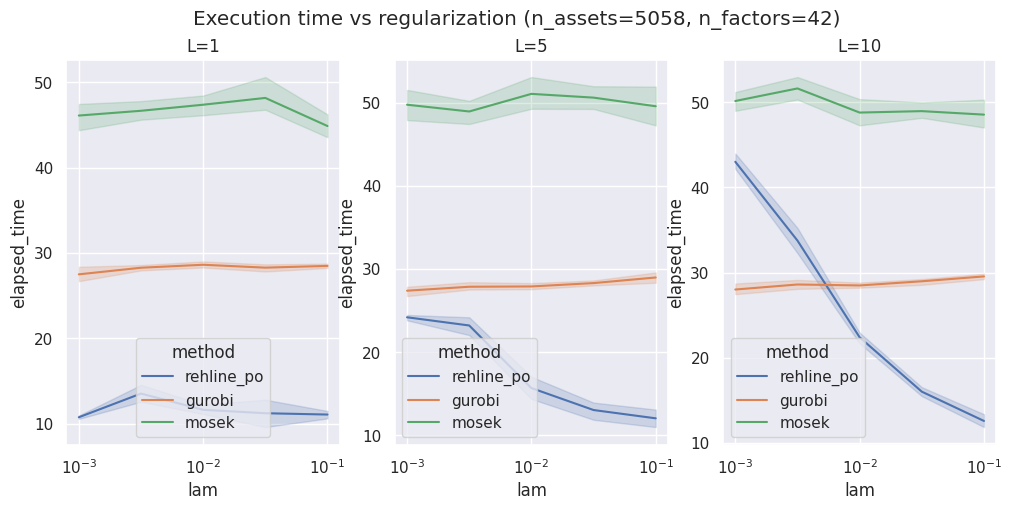

In [26]:
fig, ax = plt.subplots(1, len(Ls), figsize=(12, 5))

for i, L in enumerate(Ls):
    sns.lineplot(data_real[data_real.L == L], x="lam", y="elapsed_time", hue="method", 
                 ax=ax[i], markers=True)
    ax[i].set_xscale("log")
    ax[i].set_title(f"L={L}")

fig.suptitle(f"Execution time vs regularization (n_assets={n_assets}, n_factors={n_factors})")
plt.show()

# Appendix: complex transaction function

What if, instead of a simpler form of the transaction cost $\phi_i(w_i)$, we might have several linear pieces ($L >> 1$), i.e.
$$\phi_i(w) := p_{il} w + q_{il}, \;\; \text{if} \; w \in [d_{il}, d_{il+1}] \text{ for } l=0,...,L$$
with $d_{i0} = -\infty$ and $d_{iL+1} = +\infty$. How will MOSEK and ReHLine-PO perform for different $L$-s?

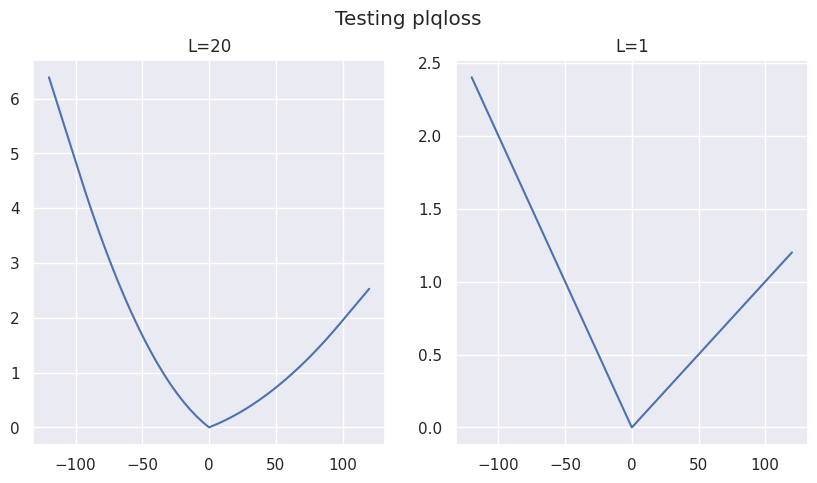

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

transaction_costs = create_plqloss_from_volume(1, V=100, L=20, vp=0.01, vm=0.02, d_vp=0.01*0.1, d_vm=0.02*0.15)
xs = np.linspace(-120, +120, 1000)
ax[0].plot(xs, transaction_costs[0](xs))
ax[0].set_title("L=20")

transaction_costs = create_plqloss_from_volume(1, V=100, L=1, vp=0.01, vm=0.02, d_vp=0.01*0.1, d_vm=0.02*0.15)
xs = np.linspace(-120, +120, 1000)
ax[1].plot(xs, transaction_costs[0](xs))
ax[1].set_title("L=1")

fig.suptitle("Testing plqloss")
plt.show()